In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import json
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

with open("audioss/labels.json","r") as f:
    labels = json.load(f)

In [2]:
def pad_mfcc(mfcc, max_len):
    # Se o MFCC for menor que o max_len, preenche com zeros
    pad_width = max_len - mfcc.shape[1]
    if pad_width > 0:
        return np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    return mfcc


In [10]:
audio_path = 'audioss/'
data = []
for x in labels:
    a = x[0]
    if(x[1]=='real'):
        g = 1

    if(x[1]=='fake'):
        g = 0
    apath = audio_path+a
    y, sr = librosa.load(apath)

    # Extrair os coeficientes MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs = pad_mfcc(mfccs,1000)
    #print(mfccs.shape,x[0])
    data.append([mfccs,g])

In [11]:
X = []
y = []
for x in data:
    X.append(x[0])
    y.append(x[1])
# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.3, random_state=42)

# Ajustar a forma de y para ser categórica (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [12]:

# Definir um bloco residual
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x  # Conexão de atalho (skip connection)
    
    # Primeira camada convolucional
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Segunda camada convolucional
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Ajustar o shortcut se o número de filtros ou a resolução mudar
    if shortcut.shape[-1] != x.shape[-1] or stride != 1:
        shortcut = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
    
    # Somar o shortcut (conexão residual) ao resultado da convolução
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


In [13]:
# Definir o modelo ResNet
def build_resnet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Camada convolucional inicial
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    # Blocos residuais (com 64 filtros)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    # Blocos residuais (com 128 filtros)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    
    # Blocos residuais (com 256 filtros)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    
    # Camada de pooling global para achatar as features
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Camada densa totalmente conectada
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    
    # Camada de saída (Softmax para 2 classes)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    
    # Criar o modelo
    model = tf.keras.Model(inputs, outputs)
    
    return model

# Definir as dimensões de entrada para a ResNet (40x1000 com 1 canal)
input_shape = (40, 1000, 1)
X_train_reshaped = X_train[..., np.newaxis]  # Adicionar canal
X_test_reshaped = X_test[..., np.newaxis]    # Adicionar canal

# Criar o modelo ResNet
model = build_resnet(input_shape)

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar a arquitetura do modelo
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 40, 1000, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_30 (Conv2D)            │ (None, 20, 500, 64)       │           3,200 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_26        │ (None, 20, 500, 64)       │             256 │ conv2d_30[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_26 (Activation)    │ (None, 20, 500, 64)       │               0 │ batch_normalization_26[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 10, 250, 64)       │               0 │ activation_26[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_31 (Conv2D)            │ (None, 10, 250, 64)       │          36,928 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_27        │ (None, 10, 250, 64)       │             256 │ conv2d_31[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_27 (Activation)    │ (None, 10, 250, 64)       │               0 │ batch_normalization_27[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_32 (Conv2D)            │ (None, 10, 250, 64)       │          36,928 │ activation_27[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_28        │ (None, 10, 250, 64)       │             256 │ conv2d_32[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_12 (Add)                  │ (None, 10, 250, 64)       │               0 │ batch_normalization_28[0]… │
│                               │                           │                 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_28 (Activation)    │ (None, 10, 250, 64)       │               0 │ add_12[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_33 (Conv2D)            │ (None, 10, 250, 64)       │          36,928 │ activation_28[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_29        │ (None, 10, 250, 64)       │             256 │ conv2d_33[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 2,814,850 (10.74 MB)

 Trainable params: 2,811,138 (10.72 MB)

 Non-trainable params: 3,712 (14.50 KB)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5529 - loss: 1.0921 - val_accuracy: 0.6607 - val_loss: 28.8582
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.7804 - loss: 0.4315 - val_accuracy: 0.6607 - val_loss: 15.5560
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.8502 - loss: 0.2850 - val_accuracy: 0.6607 - val_loss: 97.2889
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.8162 - loss: 0.2855 - val_accuracy: 0.6607 - val_loss: 41.1599
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.8525 - loss: 0.2388 - val_accuracy: 0.6607 - val_loss: 89.8070
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.8872 - loss: 0.1985 - val_accuracy: 0.6607 - val_loss: 84.6938
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.8611 - loss: 0.2738 - val_accuracy: 0.6607 - val_loss: 20.3792
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.9345 - loss: 0.1810 - val_accuracy: 0.6607 - val_loss: 23.4964


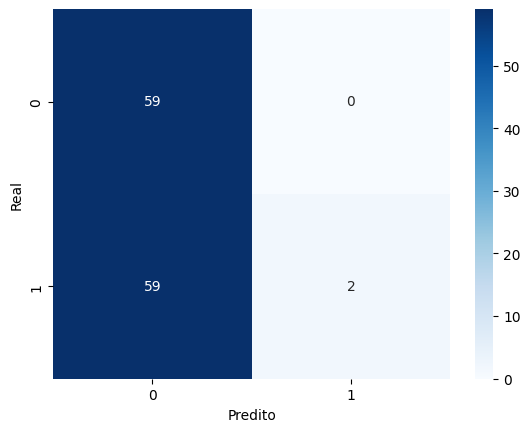

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        59
           1       1.00      0.03      0.06        61

    accuracy                           0.51       120
   macro avg       0.75      0.52      0.37       120
weighted avg       0.75      0.51      0.36       120



In [14]:
# Treinamento do modelo
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Avaliar o desempenho no conjunto de teste
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print(f"Acurácia no teste: {test_acc}")

# Prever rótulos no conjunto de teste
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Relatório de classificação
print(classification_report(y_true, y_pred_classes))
